In [1]:
#BNN USING lARQ

In [2]:
import numpy as np
np.random.seed(100)
import tensorflow as tf
tf.set_random_seed(0)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import keras
from keras.layers import Activation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from quantized.layers import QuantConv2D,QuantDense
from quantized.models import summary
from quantized.math import binary_tanh as binary_ops
from quantized.quantizers import ste_sign

Using TensorFlow backend.


In [3]:
#loading customized activation function
def binary_tanh(x):
    return binary_ops(x)

#loading and preprocessing data from dataset
#please change path as per dataset in your system
trdata = ImageDataGenerator()

traindata = trdata.flow_from_directory(directory="C:/Users/Manas/Downloads/cat-and-dog/training_set/training_set",target_size=(227,227))
trdata = ImageDataGenerator()

testdata = trdata.flow_from_directory(directory="C:/Users/Manas/Downloads/cat-and-dog/test_set/test_set",target_size=(227,227))

#kwargs: to be passed to layer of network to binarize the value and operation

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [4]:
#defining and creating the model as per architecture
model = Sequential()

#model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))

model.add(QuantConv2D(96, (11, 11),
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,strides=4, padding="valid",
                                input_shape=(227,227,3),activation = "relu"))
#model.add(tf.keras.layers.Activation("relu"))
# Max Pooling
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

# 2nd Convolutional Layer
model.add(QuantConv2D(256, (5, 5),**kwargs,
                                use_bias=False,data_format='channels_last',
                                strides=(1,1), padding="same"))
model.add(tf.keras.layers.Activation(binary_tanh))

# Max Pooling
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

# 3rd Convolutional Layer
model.add(QuantConv2D(384, (3, 3),**kwargs,
                                use_bias=False,data_format='channels_last',
                                strides=(1,1), padding="same"))
model.add(tf.keras.layers.Activation(binary_tanh))

# 4th Convolutional Layer
model.add(QuantConv2D(384, (3, 3),**kwargs,
                                use_bias=False,data_format='channels_last',
                                strides=(1,1), padding="same"))
model.add(tf.keras.layers.Activation(binary_tanh))

# 5th Convolutional Layer
model.add(QuantConv2D(256, (3, 3),**kwargs,
                                use_bias=False,data_format='channels_last',
                                strides=(1,1), padding="same"))

model.add(tf.keras.layers.Activation(binary_tanh))

# Max Pooling
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(QuantDense(9216, **kwargs))
model.add(tf.keras.layers.Activation(binary_tanh))

# 2nd Fully Connected Layer
model.add(QuantDense(4096, **kwargs))
model.add(tf.keras.layers.Activation(binary_tanh))

# 3rd Fully Connected Layer
model.add(QuantDense(4096, **kwargs))
model.add(tf.keras.layers.Activation(binary_tanh))

# Output Layer
model.add(QuantDense(2, use_bias=False, **kwargs)) #As we have two classes
model.add(tf.keras.layers.Activation("softmax"))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()
summary(model)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_conv2d (QuantConv2D)   (None, 55, 55, 96)        34848     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
quant_conv2d_1 (QuantConv2D) (None, 27, 27, 256)       614400    
_________________________________________________________________
activation (Activation)      (None, 27, 27, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
quant_conv2d_2 (QuantConv2D) (None, 13, 13, 384)       884736    
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 384)       0

In [6]:
#defining Earlystopping callback and saving the best model for future use
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("alexnet_fp_bnn.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

In [7]:
#training and validating train and validation data respectively
hist = model.fit_generator(steps_per_epoch=2,generator=traindata, validation_data= testdata, 
                           validation_steps=10,epochs=40,callbacks=[checkpoint,early])

Epoch 1/40
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1/2 [==============>...............] - ETA: 19s - loss: 33.3125 - acc: 0.5938
Epoch 00001: val_acc improved from -inf to 0.49687, saving model to alexnet_fp_bnn.h5
2/2 [==============================] - 252s 126s/step - loss: 34.5312 - acc: 0.6250 - val_loss: 1.1332 - val_acc: 0.4969
Epoch 2/40
1/2 [==============>...............] - ETA: 11s - loss: 1.1894 - acc: 0.4688
Epoch 00002: val_acc did not improve from 0.49687
2/2 [==============================] - 36s 18s/step - loss: 42.2197 - acc: 0.4531 - val_loss: 22.1375 - val_acc: 0.4969
Epoch 3/40
1/2 [==============>...............] - ETA: 8s - loss: 28.8750 - acc: 0.3438
Epoch 00003: val_acc improved from 0.49687 to 0.50313, saving model to alexnet_fp_bnn.h5
2/2 [==============================] - 86s 43s/step - loss: 39.4062 - acc: 0.4062 - val_loss: 63.6000 - val_acc: 0.5031
Epoch 4/40
1/2 [==============>...............] - ETA: 

In [8]:
#saving model for future use
model.save("model_alexnet_mnist_bnn_bit.h5")
print("Saved model to disk")

Saved model to disk


Training maximum accuracy: 62.50 %
Validation maximum accuracy: 50.31 %
Training model minimum loss: 4.321575045585632
Validation model minimum loss : 1.1331780910491944


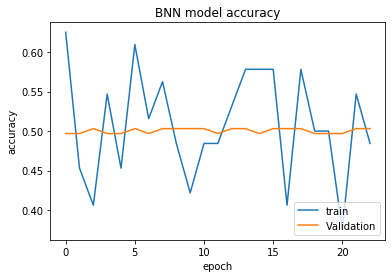

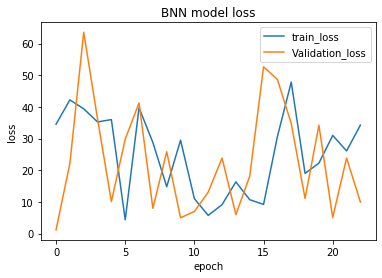

In [9]:
#Graph represenattaion of loss and accuracy
plt.figure()
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])
plt.title('BNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='lower right')
plt.figure()
print(f"Training maximum accuracy: {np.max(hist.history['acc']) * 100:.2f} %")
print(f"Validation maximum accuracy: {np.max(hist.history['val_acc']) * 100:.2f} %")
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('BNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'Validation_loss'], loc='upper right')

print(f"Training model minimum loss: {np.min(hist.history['loss'])}")
print(f"Validation model minimum loss : {np.min(hist.history['val_loss']) }")
